In [1]:
import pandas as pd
import requests
from pathlib import Path
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import AlignIO
from Bio import SearchIO
from Bio.SearchIO.HmmerIO import hmmer3_text
import scipy.stats
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import json

# Part 1: model definition

We start from the output of a BLAST search, using as seed sequence the domain sequence, against uniref50, with 1000 reported sequences.

In [4]:
#Parse blast output
input_file = 'Data/1_uniref_blast_hits.xml'

with open(input_file) as f:
  blast_records = NCBIXML.parse(f)
  data = []

  # Iterate PSIBLAST rounds (here just one since it is a simple BLAST)
  for blast_record in blast_records:
      query_id = blast_record.query

      # Iterate alignments
      for i, alignment in enumerate(blast_record.alignments):
          subject_id = alignment.title

          # Iterate pairwise alignments
          for hsp in alignment.hsps:
              data.append((query_id,
                              subject_id,
                              blast_record.query_length,
                              hsp.query,
                              hsp.match,
                              hsp.sbjct,
                              hsp.query_start,
                              hsp.query_end,
                              hsp.sbjct_start,
                              hsp.sbjct_end,
                              hsp.identities,
                              hsp.positives,
                              hsp.gaps,
                              hsp.expect,
                              hsp.score))

              # Skip duplicated subjects
              break

df = pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                  "query_seq", "match_seq", "subject_seq",
                                "query_start", "query_end", "subject_start", "subject_end",
                                "identity", "positive", "gaps", "eval", "bit_score"])
df.iloc[-1]

query_id                                                EMBOSS_001
subject_id       UR50:UniRef50_A0A4W5JGG9 Integrin beta n=2 Tax...
query_len                                                      247
query_seq        PVDLYYLMDLSYSMKDDLERVRQLGHALLVRLQEVTHSVRIGFGSF...
match_seq        P+DLY LMD S SMKDDL+ ++++G  L   + +++    IGFG F...
subject_seq      PLDLYILMDFSNSMKDDLDNLKRMGAELAELVGKLSDDYTIGFGKF...
query_start                                                      5
query_end                                                       65
subject_start                                                  132
subject_end                                                    192
identity                                                        28
positive                                                        38
gaps                                                             0
eval                                                      0.000002
bit_score                                                    1

In [104]:
# Get Uniref50 accessions
out_file = 'Data/1_uniref_accessions.list'

with open(out_file, 'w') as fout:
  accessions = list(set([acc.split()[0].split(":")[1] for acc in df['subject_id']]))
  fout.write('\n'.join(accessions) + "\n")

- Accessions were used to retrieve Uniref50 sequences
- We then aligned them with ClustalOmega, and edited the alignment in Jalview by deleting rows with redundancy >= 95%, and deleting columns to the left and right of the most conserved regions, going from around 7000 columns to around 250.
- We then generated the PSSM and HMM from the edited alignment, and used them to retrieve hits with PSI-Blast and HMMSEARCH against SwissProt
- PSSM: ncbi-blast-2.15.0+/bin/psiblast -subject Final_project/1_uniref_mapped_IDs.fasta -in_msa Final_project/1_uniref_clustal_edited.fasta -out_ascii_pssm Final_project/1_uniref_clustal.pssm_ascii -out_pssm Final_project/1_uniref_clustal.pssm
- HMM: hmmer-3.4/src/hmmbuild Final_project/1_uniref_clustal.hmm Final_project/1_uniref_clustal_edited.fasta

## Evaluate raw alignment

In [6]:
# let's look at entropy and occupancy of the raw alignment
raw_seqs = []  # [[...], ...]
with open("Data/1_uniref_clustal_raw.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        raw_seqs.append(list(record.seq))
raw_seqs = np.array(raw_seqs, dtype="str")


In [7]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
raw_data = []
for i, column in enumerate(raw_seqs.T):

    # count AA in column
    count = Counter(column)
    count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    raw_data.append([i, occupancy, entropy, count_sorted])

raw_df = pd.DataFrame(raw_data, columns=['pos', 'occupancy', 'entropy', 'counts'])


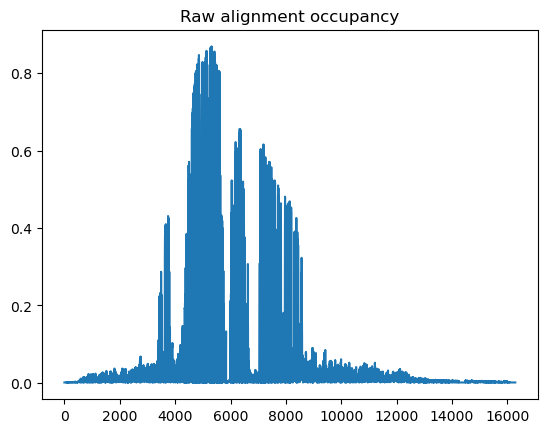

In [13]:
# Occupancy
raw_df['occupancy'].plot()
plt.title('Raw alignment occupancy')
plt.savefig('Figures/1_raw_occupancy.png')

In [10]:
raw_entropy=raw_df['entropy'].tolist()
smoothed_entropy=[sum(raw_entropy[i:i+100])/100 for i in range(len(raw_entropy)-50)]

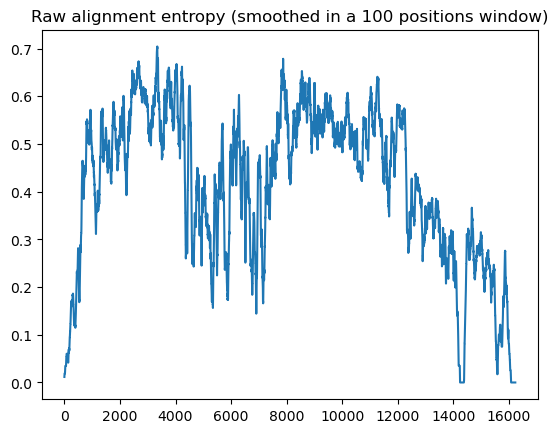

In [14]:
plt.plot(smoothed_entropy)
plt.title('Raw alignment entropy (smoothed in a 100 positions window)')
plt.savefig('Figures/1_raw_entropy.png')

From these two plots, we can see that the most informative region is around 4000-6000 positions (high occupancy, lower entropy).
We look for a stretch of a few hundreds conserved positions in this regions, and trim to the left and right of it.

In [15]:
edited_seqs=[]
with open("Data/1_uniref_clustal_edited.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        edited_seqs.append(list(record.seq))
edited_seqs = np.array(edited_seqs, dtype="str")

In [16]:
edited_data = []
for i, column in enumerate(edited_seqs.T):

    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except:
        pass
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    edited_data.append([i, occupancy, entropy, count_sorted])

edited_df = pd.DataFrame(edited_data, columns=['pos', 'occupancy', 'entropy', 'counts'])

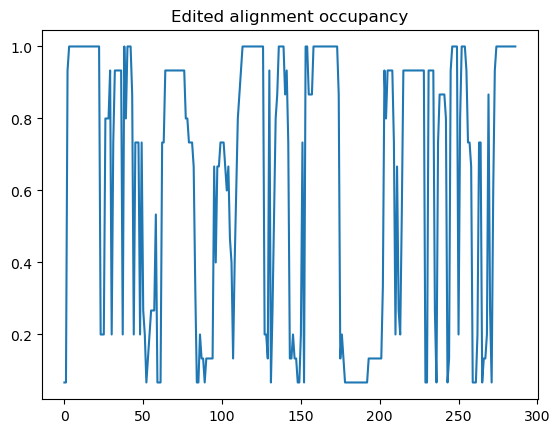

In [19]:
edited_df['occupancy'].plot()
plt.title('Edited alignment occupancy')
plt.savefig('Figures/1_edited_occupancy.png')

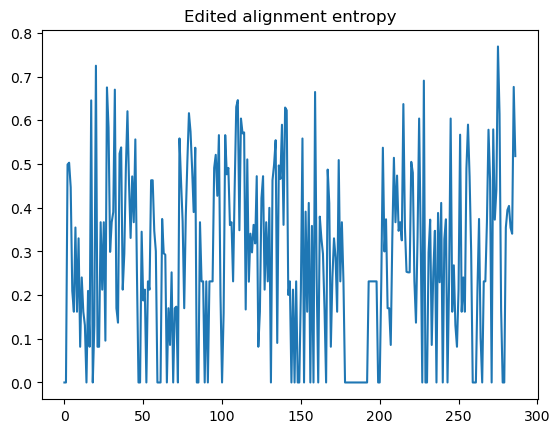

In [20]:
edited_df['entropy'].plot()
plt.title('Edited alignment entropy')
plt.savefig('Figures/1_edited_entropy.png')

# Part 2: model evaluation

## Collecting ground truth

In [2]:
# We use the interpro API to collect data on all swissprot entries with the assigned Pfam domain, and put info into a csv
accessions=[]
names=[]
length=[]
taxon=[]
start=[]
end=[]
URL="https://www.ebi.ac.uk:443/interpro/api/protein/reviewed/entry/pfam/PF00362/"
headers={'Content-Type':'application/json'}
r=requests.get(URL,headers=headers)
for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])
while r.json()['next']:
    URL=r.json()['next']
    r=requests.get(URL,headers=headers)
    for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])

In [7]:
d={'accession':accessions,'name':names,'length':length,'taxon':taxon,'start':start,'end':end}
ground_truth=pd.DataFrame(data=d)

In [8]:
ground_truth.head()

,accession,name,length,taxon,start,end
0,A2A863,Integrin beta-4,1818,10090,128,370
1,A5Z1X6,Integrin beta-1,798,9837,138,382
2,B0FYY4,Integrin beta-1,798,9940,138,382
3,O54890,Integrin beta-3,787,10090,133,380
4,O70309,Integrin beta-5,798,10090,134,382


In [ ]:
ground_truth.to_csv('Data/2_ground_truth.csv')

In [26]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

## Create confusion matrices

For the PSSM, we ran PSI-BLAST against swissprot using it as PSSM matrix.
For the HMM, due to issues with the hmmer website, we downloaded all swissprot sequences and ran it locally:
hmmer-3.4/src/hmmsearch -A uniref_hmm_aligns.txt -tblout uniref_hmm_hittbl.txt Final_project/1_uniref_clustal.hmm Final_project/swissprot_seqs.fasta

### Parse PSI-BLAST results

In [126]:
psiblast_hits=pd.read_csv('Data/2_uniref_pssm_hits.csv').iloc[:-1]
psiblast_hits.tail()

,Description(Sequences with E-value BETTER than threshold),Scientific Name,Max Score,Total Score,Query Cover,E value,Per. ident,Acc. Len,Accession
42,RecName: Full=Integrin beta-4; AltName: Full=G...,Rattus norvegicus,204,204,97%,1e-59,43.68,1807,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
43,RecName: Full=Integrin beta-4; AltName: CD_ant...,Mus musculus,203,203,97%,1e-59,43.68,1818,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
44,RecName: Full=Integrin beta-2-like protein; Al...,Mus musculus,143,143,99%,1e-38,36.51,738,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
45,RecName: Full=Integrin beta-2 [Xenopus laevis],Xenopus laevis,91.8,91.8,41%,2e-23,50.00,77,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
46,RecName: Full=Alpha-protein kinase vwkA; AltNa...,Dictyostelium discoideum,45.2,45.2,83%,1e-04,22.16,625,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."


In [119]:
pssm_accessions=[]
pssm_positions=[]
with open('Data/2_uniref_pssm_aligns.fasta') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        res=record.id.split(':')
        pssm_accessions.append(res[0].split('.')[0])
        pssm_positions.append(res[1])

In [120]:
pssm_start=[]
pssm_end=[]
for interval in pssm_positions:
    start,end=interval.split('-')
    pssm_start.append(int(start))
    pssm_end.append(int(end))

In [127]:
pssm_evalue=psiblast_hits['E value'].tolist()
pssm_cover=psiblast_hits['Query Cover'].tolist()
pssm_identity=psiblast_hits['Per. ident'].tolist()
pssm_length=psiblast_hits['Acc. Len'].tolist()

In [128]:
pssm_data={'accession':pssm_accessions,'pred_start':pssm_start,'pred_end':pssm_end,'evalue':pssm_evalue,
           'cover':pssm_cover,'identity':pssm_identity,'length':pssm_length}

In [129]:
uniref_pssm_parsed_hits=pd.DataFrame(data=pssm_data)

In [130]:
uniref_pssm_parsed_hits.to_csv('Data/2_uniref_pssm_parsed_hits.csv')

### Parse hmmsearch results

In [166]:
# Dictionary with evalues
hmm_evalues={}
with open('Data/uniref_hmm_hittbl.txt') as handle:
    for result in SearchIO.parse(handle,'hmmer3-tab'):
        for hit in result.hits:
            hmm_accessions.append(hit.id.split('|')[1])
            hmm_evalues[hit.id.split('|')[1]]=hit.evalue

In [170]:
hmm_evalues

{'Q6AYF4': 1.9e-81,
 'Q9Z0T9': 2e-81,
 'P18564': 3.5e-81,
 'P80747': 3.9e-81,
 'O70309': 4.9e-81,
 'P05106': 5.5e-81,
 'P18563': 5.8e-81,
 'P18084': 8.4e-81,
 'Q1RPR6': 9.2e-81,
 'Q863C4': 1.4e-80,
 'Q8SQB8': 1.4e-80,
 'O54890': 1.1e-79,
 'P07228': 1.1e-79,
 'Q8R2H2': 1.3e-78,
 'P05556': 4.4e-78,
 'P09055': 6e-78,
 'P49134': 6.1e-78,
 'B0FYY4': 8e-78,
 'P53712': 1.1e-77,
 'P53713': 1.4e-77,
 'A5Z1X6': 1.4e-77,
 'P12606': 1.9e-77,
 'Q9GLP0': 2.8e-77,
 'P12607': 9.5e-77,
 'P26010': 5e-76,
 'Q5RCA9': 7.8e-76,
 'P26011': 2.4e-75,
 'Q5VI41': 2.5e-74,
 'P11835': 2.5e-74,
 'Q6ECI6': 3.1e-74,
 'Q2VJ42': 3.1e-74,
 'P05107': 7.9e-74,
 'P53714': 1e-73,
 'P32592': 1.2e-73,
 'P11584': 4.3e-73,
 'Q07441': 1.5e-71,
 'Q27874': 4.5e-68,
 'Q0VBD0': 2.4e-63,
 'P26012': 4e-63,
 'P26013': 9e-63,
 'Q27591': 1.8e-62,
 'A2A863': 2.4e-59,
 'Q64632': 3.3e-59,
 'P16144': 7.5e-59,
 'Q3UV74': 2e-34,
 'Q09062': 4.3e-19,
 'Q6B9X6': 0.02,
 'Q8C6K9': 0.059,
 'A6NMZ7': 0.28,
 'O00339': 0.3,
 'Q14587': 0.31,
 'P17032': 

In [171]:
# Create lists of hits' characteristics
hmm_taxon=[]
hmm_accession=[]
hmm_start=[]
hmm_end=[]
hmm_values=[]
with open('Data/uniref_hmm_aligns.txt') as handle:
    records=SeqIO.parse(handle,'stockholm')
    for record in records:
        taxon=record.description.split('=')[2].split(' ')[0]
        rec_id=record.id.split('|')
        accession=rec_id[1]
        start,end=rec_id[2].split('/')[1].split('-')
        if hmm_evalues[accession]<0.01: #e-value threshold
            hmm_taxon.append(taxon)
            hmm_accession.append(accession)
            hmm_start.append(int(start))
            hmm_end.append(int(end))
            hmm_values.append(hmm_evalues[accession])       

In [172]:
# We're missing length
hmm_length=[]
URL='https://www.ebi.ac.uk/proteins/api'
headers={'Accept':'text/x-fasta'}
for accession in hmm_accession:
    r=requests.get(URL+'/proteins/'+accession,headers=headers)
    seq=r.text.split('\n')[1:]
    hmm_length.append(sum([len(piece) for piece in seq]))

In [173]:
hmm_data={'accession':hmm_accession,'pred_start':hmm_start,'pred_end':hmm_end,'taxon':hmm_taxon,'evalue':hmm_values
    ,'length':hmm_length}

In [174]:
uniref_hmm_parsed_hits=pd.DataFrame(data=hmm_data)

In [175]:
uniref_hmm_parsed_hits

,accession,pred_start,pred_end,taxon,evalue,length
0,Q6AYF4,129,317,10116,1.900000e-81,787
1,Q9Z0T9,129,317,10090,2.000000e-81,787
2,P18564,129,317,9606,3.500000e-81,788
3,P80747,134,323,9913,3.900000e-81,800
4,O70309,134,323,10090,4.900000e-81,798
5,P05106,134,322,9606,5.500000e-81,788
6,P18563,129,317,10141,5.800000e-81,788
7,P18084,134,323,9606,8.400000e-81,799
8,Q1RPR6,129,317,9823,9.200000e-81,788
9,Q863C4,129,317,9940,1.400000e-80,787


For uniprot accession Q3UV74, we have 2 hits, for 2 candidate regions of the protein to have the domain.

In [176]:
uniref_hmm_parsed_hits.to_csv('Data/2_uniref_hmm_parsed_hits.csv')

### Protein confusion matrix

In [2]:
ground_truth=pd.read_csv('Data/2_ground_truth.csv')
uniref_pssm_parsed_hits=pd.read_csv('Data/2_uniref_pssm_parsed_hits.csv')
uniref_hmm_parsed_hits=pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

#### PSSM

In [42]:
predicted_accessions=uniref_pssm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [43]:
truth=['domain' if ID in true_accessions else 'no domain' for ID in swissprot_IDs]
pred=['domain' if ID in predicted_accessions else 'no domain' for ID in swissprot_IDs]

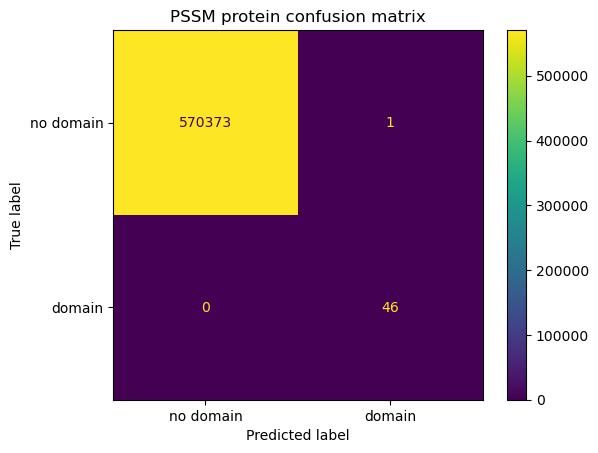

In [46]:
disp=ConfusionMatrixDisplay.from_predictions(truth,pred,labels=['no domain','domain'])
disp.ax_.set_title('PSSM protein confusion matrix')
disp.figure_.savefig('Figures/2_protein_pssm.png')

#### HMM

In [47]:
predicted_accessions=uniref_hmm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [48]:
truth=['domain' if ID in true_accessions else 'no domain' for ID in swissprot_IDs]
pred=['domain' if ID in predicted_accessions else 'no domain' for ID in swissprot_IDs]

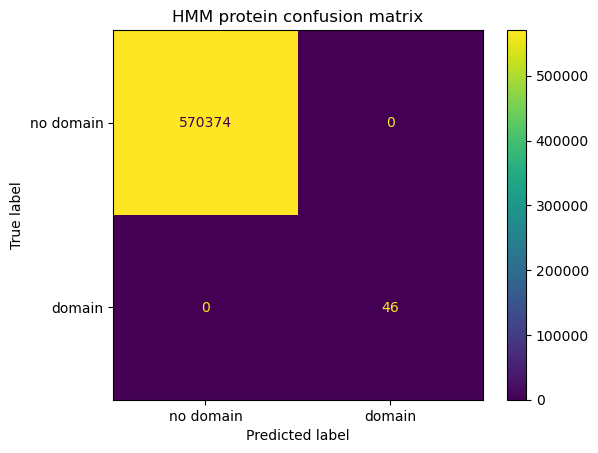

In [49]:
disp=ConfusionMatrixDisplay.from_predictions(truth,pred,labels=['no domain','domain'])
disp.ax_.set_title('HMM protein confusion matrix')
disp.figure_.savefig('Figures/2_protein_hmm.png')

### Residue level results

For the true positives, we evaluate the model's ability to identify the correct position of the domain.

#### PSSM

In [3]:
merged_data=ground_truth.merge(uniref_pssm_parsed_hits,on='accession',how='inner')

In [4]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_pssm_matrix=np.array([[tn,fp],[fn,tp]])

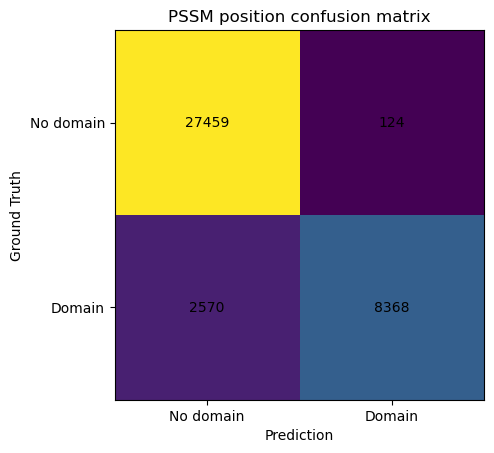

In [14]:
# Display confusion matrix
fig,ax=plt.subplots(1)
ax.imshow(res_pssm_matrix)
for (j,i),label in np.ndenumerate(res_pssm_matrix):
    ax.text(i,j,label,ha='center',va='center')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('PSSM position confusion matrix')
ax.set_xticks(ticks=[0,1],labels=['No domain','Domain'])
ax.set_yticks(ticks=[0,1],labels=['No domain','Domain'])
fig.savefig('Figures/2_position_pssm.png')

In [135]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9853980216674517
Recall:0.7650393124885719
F-score:0.8613484302624806
Balanced accuracy:0.8802718949420345


#### HMM

In [15]:
merged_data=ground_truth.merge(uniref_hmm_parsed_hits,on='accession',how='inner')

In [16]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_hmm_matrix=np.array([[tn,fp],[fn,tp]])

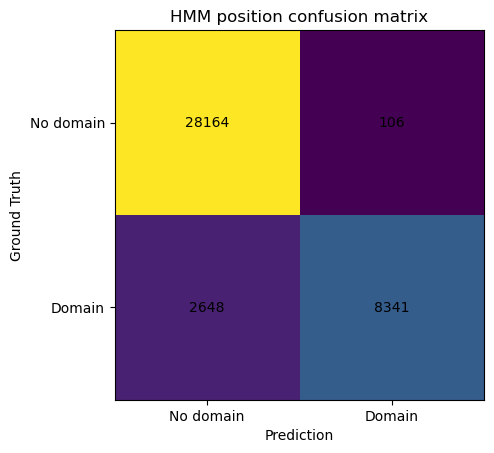

In [17]:
fig,ax=plt.subplots(1)
ax.imshow(res_hmm_matrix)
for (j,i),label in np.ndenumerate(res_hmm_matrix):
    ax.text(i,j,label,ha='center',va='center')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('HMM position confusion matrix')
ax.set_xticks(ticks=[0,1],labels=['No domain','Domain'])
ax.set_yticks(ticks=[0,1],labels=['No domain','Domain'])
fig.savefig('Figures/2_position_hmm.png')

In [184]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9874511660944714
Recall:0.759031759031759
F-score:0.8583041778143651
Balanced accuracy:0.877641100598299


#### Discussion
The models perform very similarly, but the HMM manages to avoid the single false positive the PSSM finds.
For the next parts we will use the HMM hits.

### Visualizing true and predicted domain positions

In [19]:
# We use the positions predicted by the HMM
merged_data.head()

,Unnamed: 0_x,accession,name,length_x,taxon_x,start,end,Unnamed: 0_y,pred_start,pred_end,taxon_y,evalue,length_y
0,0,A2A863,Integrin beta-4,1818,10090,128,370,41,129,312,10090,2.400000e-59,1818
1,1,A5Z1X6,Integrin beta-1,798,9837,138,382,20,138,323,9837,1.400000e-77,798
2,2,B0FYY4,Integrin beta-1,798,9940,138,382,17,138,323,9940,8.000000e-78,798
3,3,O54890,Integrin beta-3,787,10090,133,380,11,133,321,10090,1.100000e-79,787
4,4,O70309,Integrin beta-5,798,10090,134,382,4,134,323,10090,4.900000e-81,798


In [27]:
true_pos=[((row['start'],4*index+2),(row['end'],4*index+2)) for index,row in merged_data.iterrows()]

In [28]:
pred_pos=[((row['pred_start'],4*index+4),(row['pred_end'],4*index+4)) for index,row in merged_data.iterrows()]

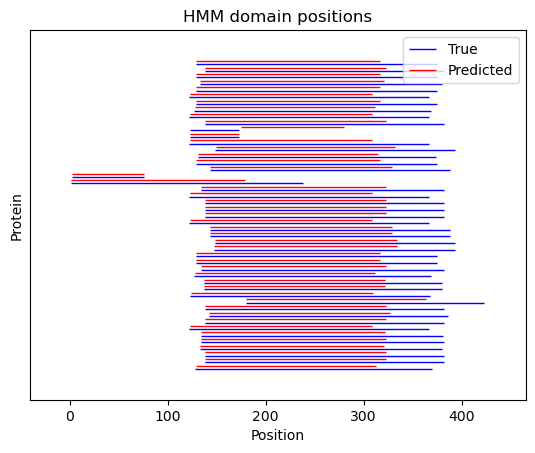

In [39]:
from matplotlib import collections  as mc
lc1 = mc.LineCollection(true_pos, colors='blue', linewidths=1,label='True')
lc2= mc.LineCollection(pred_pos, colors='red', linewidths=1,label='Predicted')
fig, ax = plt.subplots()
ax.add_collection(lc1)
ax.add_collection(lc2)
ax.autoscale()
ax.margins(0.1)
ax.legend()
ax.set_yticks([])
ax.set_xlabel('Position')
ax.set_ylabel('Protein')
ax.set_title('HMM domain positions')
fig.savefig('Figures/2_domain_positions.png')

# Part 3: taxonomy

In [3]:
hits=pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')

In [8]:
hits.head()

,Unnamed: 0,accession,pred_start,pred_end,taxon,evalue,length
0,0,Q6AYF4,129,317,10116,1.900000e-81,787
1,1,Q9Z0T9,129,317,10090,2.000000e-81,787
2,2,P18564,129,317,9606,3.500000e-81,788
3,3,P80747,134,323,9913,3.900000e-81,800
4,4,O70309,134,323,10090,4.900000e-81,798


In [11]:
taxa = hits['taxon'].apply(str).tolist()

## Collect lineages

In [5]:
URL = "https://www.ebi.ac.uk/proteins/api/taxonomy"   
# Dictionary with lineage of each entry
lineages={}
headers={'Accept':'application/json'}
for index,row in hits.iterrows():
    new_entry=[]
    accession=row['accession']
    taxon=row['taxon']
    Req_url='{}/lineage/{}'.format(URL,taxon)
    r=requests.get(Req_url,headers=headers).json()
    for node in r['taxonomies']:
        new_entry.append((node['rank'],node['scientificName'],node['taxonomyId']))
    lineages[accession]=new_entry[::-1]
            

In [82]:
lineages

{'Q6AYF4': [('no rank', 'root', 1),
  ('no rank', 'cellular organisms', 131567),
  ('superkingdom', 'Eukaryota', 2759),
  ('no rank', 'Opisthokonta', 33154),
  ('kingdom', 'Metazoa', 33208),
  ('no rank', 'Eumetazoa', 6072),
  ('no rank', 'Bilateria', 33213),
  ('no rank', 'Deuterostomia', 33511),
  ('phylum', 'Chordata', 7711),
  ('subphylum', 'Craniata', 89593),
  ('no rank', 'Vertebrata', 7742),
  ('no rank', 'Gnathostomata', 7776),
  ('no rank', 'Teleostomi', 117570),
  ('no rank', 'Euteleostomi', 117571),
  ('superclass', 'Sarcopterygii', 8287),
  ('no rank', 'Dipnotetrapodomorpha', 1338369),
  ('no rank', 'Tetrapoda', 32523),
  ('no rank', 'Amniota', 32524),
  ('class', 'Mammalia', 40674),
  ('no rank', 'Theria', 32525),
  ('no rank', 'Eutheria', 9347),
  ('no rank', 'Boreoeutheria', 1437010),
  ('superorder', 'Euarchontoglires', 314146),
  ('no rank', 'Glires', 314147),
  ('order', 'Rodentia', 9989),
  ('suborder', 'Myomorpha', 1963758),
  ('no rank', 'Muroidea', 337687),
  ('fa

In [7]:
#Dictionary of abundances
weights={}
for lineage in lineages.values():
    for triplet in lineage:
        taxid=triplet[2]
        if taxid in weights.keys():
            weights[taxid]+=1
        else:
            weights[taxid]=1
weights

{1: 46,
 131567: 46,
 2759: 46,
 33154: 46,
 33208: 46,
 6072: 46,
 33213: 46,
 33511: 43,
 7711: 43,
 89593: 43,
 7742: 43,
 7776: 43,
 117570: 43,
 117571: 43,
 8287: 43,
 1338369: 43,
 32523: 43,
 32524: 40,
 40674: 39,
 32525: 39,
 9347: 39,
 1437010: 39,
 314146: 25,
 314147: 15,
 9989: 14,
 1963758: 13,
 337687: 13,
 10066: 13,
 39107: 13,
 10114: 4,
 10116: 4,
 10088: 9,
 862507: 9,
 10090: 9,
 9443: 10,
 376913: 10,
 314293: 10,
 9526: 10,
 314295: 9,
 9604: 9,
 207598: 8,
 9605: 8,
 9606: 8,
 314145: 14,
 91561: 13,
 9845: 9,
 35500: 9,
 9895: 9,
 27592: 4,
 9903: 4,
 9913: 4,
 33550: 1,
 10139: 1,
 10140: 1,
 10141: 1,
 35497: 3,
 9821: 3,
 9822: 3,
 9823: 3,
 9963: 5,
 9935: 4,
 9940: 3,
 8457: 1,
 32561: 1,
 1329799: 1,
 8492: 1,
 436486: 1,
 436489: 1,
 436491: 1,
 436492: 1,
 8782: 1,
 8825: 1,
 1549675: 1,
 8976: 1,
 9005: 1,
 9072: 1,
 9030: 1,
 9031: 1,
 33554: 1,
 379583: 1,
 9681: 1,
 338152: 1,
 9682: 1,
 9685: 1,
 9834: 1,
 9835: 1,
 9836: 1,
 9837: 1,
 8292: 3,
 4

In [46]:
# Create table with lineage of each entry
# We take the named ranks shared by all entries
shared=[]
for lineage in lineages.values():
    ranks=[item[0] for item in lineage if item[0]!='no rank']
    if shared==[]:
        shared=ranks
    else:
        shared=[rank for rank in ranks if rank in shared]

['superkingdom',
 'kingdom',
 'phylum',
 'class',
 'order',
 'family',
 'genus',
 'species']

In [48]:
shared_lineages=[]
for key,value in lineages.items():
    new_lineage=[key]
    for rank,name in value:
        if rank in shared:
            new_lineage.append(name)
    shared_lineages.append(new_lineage)

In [51]:
lineage_data=pd.DataFrame(shared_lineages,columns=['accession']+shared)

In [52]:
lineage_data.to_csv('Data/3_lineages.csv')

Create annotated tree

In [8]:
import ete3
from ete3 import NCBITaxa
from ete3 import NodeStyle, TreeStyle,TextFace
ncbi = NCBITaxa()

In [9]:
translator = ncbi.get_taxid_translator(weights.keys())

In [18]:
# Define tree
tree = ncbi.get_topology(taxa)
# Add scientific names
for n in tree.traverse():
    n.add_feature('scientificName',translator[int(n.name)])
# Add abundances
for n in tree.traverse():
    n.add_feature('weight',weights[int(n.name)])
# Add labels to nodes
for n in tree.traverse():
    n.add_face(TextFace(n.scientificName), column=0, position ="branch-right")
    n.add_face(TextFace(n.weight), column=1, position ="branch-right")
# Draw nodes based on weight 
for n in tree.traverse():
    nstyle=NodeStyle()
    nstyle['shape']='circle'
    nstyle['fgcolor']='red'
    n.set_style(nstyle)
    n.img_style['size']=5*n.weight
    print(n.img_style['size'])
ts=TreeStyle()
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
ts.show_leaf_name = False
ts.mode = "r"
tree.show(tree_style=ts)

230
15
215
5
10
200
15
195
5
125
70
75
50
65
5
70
5
45
5
45
5
15
65
5
5
40
25
20
20
45
20
5
15
5


AttributeError: '_TreeScene' object has no attribute 'selector'

In [19]:
tree.render('3_tree_image.png')

{'nodes': [[20.5, 270.654296875, 23.5, 273.654296875, 0, None],
  [110.5, 32.5, 113.5, 35.5, 1, None],
  [210.5, 16.0, 213.5, 19.0, 2, None],
  [210.5, 49.0, 213.5, 52.0, 3, None],
  [110.5, 508.80859375, 113.5, 511.80859375, 4, None],
  [215.5, 440.6171875, 218.5, 443.6171875, 5, None],
  [306.5, 337.234375, 309.5, 340.234375, 6, None],
  [435.5, 203.6875, 438.5, 206.6875, 7, None],
  [582.5, 152.125, 585.5, 155.125, 8, None],
  [655.5, 123.25, 658.5, 126.25, 9, None],
  [750.5, 98.5, 753.5, 101.5, 10, None],
  [839.5, 82.0, 842.5, 85.0, 11, None],
  [839.5, 115.0, 842.5, 118.0, 12, None],
  [750.5, 148.0, 753.5, 151.0, 13, None],
  [655.5, 181.0, 658.5, 184.0, 14, None],
  [582.5, 255.25, 585.5, 258.25, 15, None],
  [683.5, 230.5, 686.5, 233.5, 16, None],
  [779.5, 214.0, 782.5, 217.0, 17, None],
  [779.5, 247.0, 782.5, 250.0, 18, None],
  [683.5, 280.0, 686.5, 283.0, 19, None],
  [435.5, 470.78125, 438.5, 473.78125, 20, None],
  [565.5, 430.5625, 568.5, 433.5625, 21, None],
  [683.5

# Part 4: Function

In [1]:
#!pip install cafaeval

     ---------------------------------------- 0.0/51.3 kB ? eta -:--:--
     ---------------------------------------- 51.3/51.3 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/68.9 kB ? eta -:--:--
   ---------------------------------------- 68.9/68.9 kB 3.9 MB/s eta 0:00:00


In [40]:
import gzip
import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser
import xml.etree.ElementTree as ET
import re
from tqdm import tqdm

In [41]:
# Parse ontology
ontologies = obo_parser('Data/go.obo')
namespaces = ['molecular_function', 'biological_process', 'cellular_component']

In [42]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()
family_IDs=set(pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')['accession'].tolist())

In [6]:
URL = "https://rest.uniprot.org"

## Family annotations

In [71]:
# Get GO annotations for our family

family_annotations={}
for fam_id in tqdm(family_IDs):
    id_annotations=[]
    r = requests.get("{}/uniprot/{}.xml".format(URL,fam_id))  # Without extension, it will look at the 'Accept' header
    NS = {'uniprot': 'http://uniprot.org/uniprot'}
    root = ET.fromstring(r.text)

    for ele in root.findall("uniprot:entry/uniprot:dbReference", NS):
        if ele.attrib["type"] == "GO":
            id_annotations.append(ele.attrib['id'])
    family_annotations[fam_id]=id_annotations

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:46<00:00,  1.00s/it]


## Swissprot annotations

In [10]:
#GO ids for entire swissprot, downloaded from the UniProtKB website
swissprot_go=pd.read_csv('Data/swissprot_GO.tsv',sep='\t')

In [25]:
swissprot_go.fillna('',inplace=True)

In [12]:
# Build set of annotations present in our family
family_terms=set()
for annotation_list in family_annotations.values():
    family_terms=family_terms.union(set(annotation_list))

In [84]:
len(family_terms)

390

In [26]:
swissprot_go.iloc[418]

Entry                A0A4Y1WBN6
Reviewed               reviewed
Gene Ontology IDs              
Name: 418, dtype: object

## Enrichment

In [27]:
# Now, build dictionary with, for each GO term that appears in the family, the number of times it appears in the family,and the rest of swissprot
go_freqs={}
for index,row in tqdm(swissprot_go.iterrows()):
    if GO_terms:
        GO_terms=row['Gene Ontology IDs'].split('; ')
        for go in GO_terms:
            if go in family_terms:
                if go not in go_freqs.keys():
                    go_freqs[go]=[0,0]
                if row['Entry'] in family_IDs:
                    go_freqs[go][0] += 1
                else:
                    go_freqs[go][1] += 1

570420it [00:33, 16974.86it/s]


In [48]:
#Create Dataframe
go_data=pd.DataFrame.from_dict(data=go_freqs,orient='index',columns=['family','rest'])

In [50]:
go_data['not_family']=len(family_IDs)-go_data['family']

In [51]:
go_data['not_rest']=len(swissprot_IDs)-len(family_IDs)-go_data['rest']

In [53]:
go_data['family_ratio']=go_data['family']/go_data['not_family']
go_data['rest_ratio']=go_data['rest']/go_data['not_rest']
go_data['fold'] = go_data['family_ratio'] / go_data['rest_ratio']

In [55]:
go_data.loc[go_data['family_ratio']>0.3].sort_values(['fold'], ascending=False).head()

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold
GO:0007229,46,277,0,570097,inf,0.000486,inf
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03
GO:0071404,16,66,30,570308,0.533333,0.000116,4.608549e+03
GO:0034113,11,60,35,570314,0.314286,0.000105,2.987359e+03


In [62]:
#Perform Fisher's exact test, two-tailed
#We use a significance level of p=0.05
from scipy.stats import fisher_exact

In [65]:
pvalues=[]
for index,row in go_data.iterrows():
    test_table=np.array([[row['family'],row['rest']],[row['not_family'],row['not_rest']]])
    res_both=fisher_exact(test_table,)
    pvalues.append(res_both[1])

In [67]:
go_data['p-values']=pvalues

In [77]:
go_data.loc[go_data['family_ratio']>0.3].sort_values(['p-values'], ascending=True).head()

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values
GO:0007229,46,277,0,570097,inf,0.000486,inf,1.503644e-151
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04,1.291198e-116
GO:0005925,38,922,8,569452,4.750000,0.001619,2.933728e+03,4.788946e-98
GO:0005178,33,533,13,569841,2.538462,0.000935,2.713920e+03,3.007991e-89
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03,8.582342e-70


In [82]:
go_data.sort_values('p-values',axis=0)

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values
GO:0007229,46,277,0,570097,inf,0.000486,inf,1.503644e-151
GO:0008305,33,65,13,570309,2.538462,0.000114,2.227242e+04,1.291198e-116
GO:0005925,38,922,8,569452,4.750000,0.001619,2.933728e+03,4.788946e-98
GO:0005178,33,533,13,569841,2.538462,0.000935,2.713920e+03,3.007991e-89
GO:0033627,22,96,24,570278,0.916667,0.000168,5.445363e+03,8.582342e-70
...,...,...,...,...,...,...,...,...
GO:0043025,1,1884,45,568490,0.022222,0.003314,6.705473e+00,1.412424e-01
GO:0030425,1,2089,45,568285,0.022222,0.003676,6.045264e+00,1.553717e-01
GO:0006915,1,2279,45,568095,0.022222,0.004012,5.539418e+00,1.682640e-01
GO:0005615,1,8270,45,562104,0.022222,0.014713,1.510423e+00,4.892639e-01


In [86]:
go_names=[]
for index,row in go_data.iterrows():
    for ns in namespaces:
        try:
            go_names.append(ontologies[ns].terms_dict[index]['name'])
        except:
            pass

In [87]:
go_data['name']=go_names

In [97]:
#Adjust for multiple testing
from scipy.stats import false_discovery_control
adj_pvalues=false_discovery_control(go_data['p-values'])

In [99]:
go_data['adj_pvalue']=adj_pvalues

In [103]:
enriched_terms=go_data[go_data['adj_pvalue'] < 0.05] 

In [105]:
enriched_terms_sorted=enriched_terms.sort_values('adj_pvalue',axis=0)

In [106]:
enriched_terms

,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,name,adj_pvalue
GO:0005813,3,1894,43,568480,0.069767,0.003332,2.094055e+01,5.009615e-04,centrosome,7.104544e-04
GO:0016020,19,22333,27,548041,0.703704,0.040751,1.726855e+01,2.758773e-15,membrane,2.338960e-14
GO:0046872,41,58721,5,511653,8.200000,0.114767,7.144896e+01,2.694844e-35,metal ion binding,6.568683e-34
GO:0005886,22,67367,24,503007,0.916667,0.133929,6.844445e+00,1.749488e-09,plasma membrane,6.038056e-09
GO:0005737,3,163637,43,406737,0.069767,0.402316,1.734143e-01,4.377325e-04,cytoplasm,6.276312e-04
...,...,...,...,...,...,...,...,...,...,...
GO:0003366,2,2,44,570372,0.045455,0.000004,1.296300e+04,3.816702e-08,cell-matrix adhesion involved in ameboidal cel...,1.026561e-07
GO:0034669,2,2,44,570372,0.045455,0.000004,1.296300e+04,3.816702e-08,integrin alpha4-beta7 complex,1.026561e-07
GO:0001573,2,6,44,570368,0.045455,0.000011,4.320970e+03,1.780761e-07,ganglioside metabolic process,4.037772e-07
GO:0099561,1,0,45,570374,0.022222,0.000000,inf,8.064233e-05,synaptic membrane adhesion to extracellular ma...,1.299608e-04


In [63]:
terms_ontologies={}
for go_id in enriched_terms.index:
    for ns in namespaces:
        try:
            _=ontologies[ns].terms_dict[go_id]
            terms_ontologies[go_id]=ns
        except:
            pass

In [16]:
enriched_terms['ontology']=pd.Series(terms_ontologies)

In [19]:
columns=['name','ontology','family','rest','not_family','not_rest','family_ratio','rest_ratio','fold','p-values','adj_pvalue']

In [25]:
enriched_terms=enriched_terms[columns]
enriched_terms=enriched_terms.sort_values('adj_pvalue',axis=0)

In [27]:
enriched_terms.tail()

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue
GO:0007156,homophilic cell adhesion via plasma membrane a...,biological_process,1,496,45,569878,0.022222,0.000870,25.532168,0.039305,0.041318
GO:0030018,Z disc,cellular_component,1,517,45,569857,0.022222,0.000907,24.494176,0.040932,0.042913
GO:0007267,cell-cell signaling,biological_process,1,539,45,569835,0.022222,0.000946,23.493506,0.042634,0.044577
GO:0042734,presynaptic membrane,cellular_component,1,566,45,569808,0.022222,0.000993,22.371731,0.044718,0.046631
GO:0007005,mitochondrion organization,biological_process,1,606,45,569768,0.022222,0.001064,20.893583,0.047798,0.049710


In [28]:
enriched_terms.to_csv('Data/4_enriched_terms.csv')

In [ ]:
# We have 375 enriched terms

## Word cloud

In [30]:
from wordcloud import WordCloud,STOPWORDS

In [2]:
enriched_terms=pd.read_csv('Data/4_enriched_terms.csv',index_col='Unnamed: 0')

In [31]:
stopwords = set(STOPWORDS)

In [32]:
words=''
for name in enriched_terms['name']:
    new_words=name.lower()
    words +=new_words+" "
    
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)

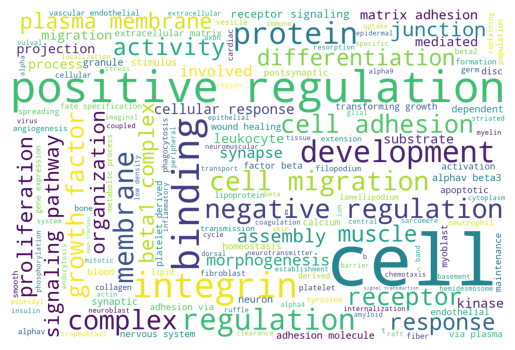

In [41]:
fig,ax=plt.subplots()
ax.set_axis_off()
ax.imshow(wordcloud)

In [42]:
fig.savefig('Figures/4_word_cloud.png')

## Enriched top level terms

In [59]:
enriched_terms=pd.read_csv('Data/4_enriched_terms.csv',index_col='Unnamed: 0')

In [24]:
enriched_terms.head()

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue
GO:0005813,centrosome,cellular_component,3,1894,43,568480,0.069767,0.003332,20.940547,5.009615e-04,7.104544e-04
GO:0016020,membrane,cellular_component,19,22333,27,548041,0.703704,0.040751,17.268548,2.758773e-15,2.338960e-14
GO:0046872,metal ion binding,molecular_function,41,58721,5,511653,8.200000,0.114767,71.448964,2.694844e-35,6.568683e-34
GO:0005886,plasma membrane,cellular_component,22,67367,24,503007,0.916667,0.133929,6.844445,1.749488e-09,6.038056e-09
GO:0005737,cytoplasm,cellular_component,3,163637,43,406737,0.069767,0.402316,0.173414,4.377325e-04,6.276312e-04


In [60]:
def depth_first_search(matrix, node, visited):

  # Set current node as visited
  visited[node] = 1

  # For every node of the graph
  for j in range(matrix.shape[0]):

    # If some node is adjacent to the current node and it has not already been visited
    if (matrix[node][j] == 1 and (not visited[j])):
        depth_first_search(matrix, j, visited)

In [61]:
enriched_ids=enriched_terms.index.tolist()

In [64]:
#Strategy: we start from each enriched term, and create a set of their children
#We then select the enriched terms that aren't children of other terms
# And sort them first by ontology, then topologically
# 1st:dictionary of ontologies
children=[]
for go_id in enriched_ids:
    if go_id not in children: # Avoid visiting nodes multiple times
        ns=terms_ontologies[go_id]
        term_index = ontologies[ns].terms_dict[go_id]['index']
        visited = np.zeros(ontologies[ns].dag.shape[0])
        depth_first_search(ontologies[ns].dag.T, term_index, visited)
        for go_index in np.nonzero(visited)[0][1:]:  # Exclude first visited node
            children.append(ontologies[ns].terms_list[go_index]['id'])
children=set(children)
children

{'GO:0000328',
 'GO:0002723',
 'GO:0034516',
 'GO:0038191',
 'GO:1901165',
 'GO:0014027',
 'GO:0060945',
 'GO:0070781',
 'GO:1903214',
 'GO:0097485',
 'GO:0031175',
 'GO:0048685',
 'GO:0030672',
 'GO:1900075',
 'GO:0021579',
 'GO:0032629',
 'GO:0016282',
 'GO:0086102',
 'GO:0060114',
 'GO:0061909',
 'GO:0008031',
 'GO:0016272',
 'GO:0030285',
 'GO:0062157',
 'GO:0000838',
 'GO:1905819',
 'GO:1990317',
 'GO:0034424',
 'GO:0031750',
 'GO:1900199',
 'GO:0042740',
 'GO:0032731',
 'GO:0034236',
 'GO:0035478',
 'GO:0099553',
 'GO:0000839',
 'GO:0005943',
 'GO:0009316',
 'GO:0071404',
 'GO:0033065',
 'GO:0032055',
 'GO:2000701',
 'GO:0070662',
 'GO:0099192',
 'GO:1901028',
 'GO:1903054',
 'GO:0060704',
 'GO:0042200',
 'GO:0140240',
 'GO:0043320',
 'GO:0060490',
 'GO:0060489',
 'GO:0036364',
 'GO:0035315',
 'GO:1990657',
 'GO:0021729',
 'GO:0090010',
 'GO:0033113',
 'GO:0035082',
 'GO:0032875',
 'GO:0021906',
 'GO:0110021',
 'GO:1901392',
 'GO:0071678',
 'GO:1902808',
 'GO:0061351',
 'GO:00027

In [65]:
top_terms=(set(enriched_ids)-children)

In [66]:
top_level=enriched_terms[enriched_terms.index.isin(top_terms)]

In [81]:
top_level

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue,go_index
GO:0007229,integrin-mediated signaling pathway,biological_process,46,277,0,570097,inf,0.000486,inf,1.503644e-151,5.864212e-149,2898
GO:1901388,regulation of transforming growth factor beta ...,biological_process,10,10,36,570364,0.277778,0.000018,1.584344e+04,7.489809e-37,2.246943e-35,22913
GO:0010710,regulation of collagen catabolic process,biological_process,9,3,37,570371,0.243243,0.000005,4.624630e+04,1.375480e-35,3.576247e-34,4508
GO:0007520,myoblast fusion,biological_process,12,94,34,570280,0.352941,0.000165,2.141227e+03,3.439143e-35,7.889798e-34,3127
GO:0001968,fibronectin binding,molecular_function,10,114,36,570260,0.277778,0.000200,1.389522e+03,6.575690e-28,1.115008e-26,280
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0042802,identical protein binding,molecular_function,3,7615,43,562759,0.069767,0.013532,5.155910e+00,2.359779e-02,2.556427e-02,5725
GO:0050766,positive regulation of phagocytosis,biological_process,1,314,45,570060,0.022222,0.000551,4.034395e+01,2.509023e-02,2.710579e-02,14390
GO:0001726,ruffle,cellular_component,1,378,45,569996,0.022222,0.000663,3.350947e+01,3.011213e-02,3.244124e-02,157
GO:0007608,sensory perception of smell,biological_process,1,420,45,569954,0.022222,0.000737,3.015630e+01,3.339399e-02,3.568125e-02,3196


In [70]:
go_indexes=[]
for go_id in top_level.index:
    go_indexes.append(ontologies[terms_ontologies[go_id]].terms_dict[go_id]['index'])
top_level['go_index']=go_indexes

C:\Users\Silvia\AppData\Local\Temp\ipykernel_4424\2622844414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_level['go_index']=go_indexes


In [82]:
topological_sorting={}
for ns in namespaces:
    topological_sorting[ns]=[go_i for go_i in ontologies[ns].order if go_i in go_indexes]

In [92]:
sorted_df=[]
for ns in namespaces:
    sort_list=topological_sorting[ns]
    to_sort=top_level[top_level['ontology']==ns]
    to_sort.go_index=pd.Categorical(to_sort.go_index,categories=sort_list)
    to_sort=to_sort.sort_values('go_index')
    sorted_df.append(to_sort)

C:\Users\Silvia\AppData\Local\Temp\ipykernel_4424\2563590084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_sort.go_index=pd.Categorical(to_sort.go_index,categories=sort_list)


In [95]:
branches=pd.concat(sorted_df)

In [96]:
branches

,name,ontology,family,rest,not_family,not_rest,family_ratio,rest_ratio,fold,p-values,adj_pvalue,go_index
GO:0001540,amyloid-beta binding,molecular_function,5,300,41,570074,0.121951,0.000526,231.737398,5.693495e-11,2.775579e-10,189
GO:0001618,virus receptor activity,molecular_function,9,162,37,570212,0.243243,0.000284,856.174174,1.722732e-23,2.488391e-22,210
GO:0001851,complement component C3b binding,molecular_function,2,18,44,570356,0.045455,0.000032,1440.292929,1.207628e-06,2.343159e-06,253
GO:0001968,fibronectin binding,molecular_function,10,114,36,570260,0.277778,0.000200,1389.522417,6.575690e-28,1.115008e-26,280
GO:0003756,protein disulfide isomerase activity,molecular_function,3,170,43,570204,0.069767,0.000298,234.009850,4.121801e-07,8.642486e-07,352
...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0035748,myelin sheath abaxonal region,cellular_component,3,20,43,570354,0.069767,0.000035,1989.606977,8.680976e-10,3.224362e-09,1706
GO:0001726,ruffle,cellular_component,1,378,45,569996,0.022222,0.000663,33.509465,3.011213e-02,3.244124e-02,157
GO:0030175,filopodium,cellular_component,3,341,43,570033,0.069767,0.000598,116.626816,3.237418e-06,5.955627e-06,935
GO:0005911,cell-cell junction,cellular_component,5,662,41,569712,0.121951,0.001162,104.950262,2.837113e-09,9.621513e-09,446


In [97]:
branches.to_csv('Data/4_branches.csv')

# Part 5: Motifs

In [98]:
import re
import requests
family_IDs=set(pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')['accession'].tolist())
disorder=pd.read_csv('Data/mobidb_lite_swissprot.csv',header=None,index_col=0)
elm_classes=pd.read_csv('Data/elm_classes.tsv',sep='\t',header=0,index_col='Accession')

In [99]:
# Create list of disordered regions of family
family_disorder=[]
URL='https://www.uniprot.org/uniprotkb/'
for fam_id in list(family_IDs):
    r=requests.get(url=URL+'/{}.fasta'.format(fam_id))
    sequence=''.join(r.text.split('\n')[1:])
    try:
        string_pairs=disorder.loc[fam_id][1].replace('[',']').split(']')
        for pair in string_pairs:
            if len(pair)>2:
                print(pair)
                start,end=pair.split(',')
                disordered_region=sequence[int(start):int(end)+1]
                family_disorder.append(disordered_region)
    except:
        print('Exception')       # No disorder in entry      

76,104
1113,1140
1400,1444
1495,1525
Exception
75,107
77,106
Exception
Exception
75,107
Exception
Exception
Exception
Exception
Exception
Exception
Exception
Exception
Exception
75,105
Exception
75,105
98,123
786,806
Exception
Exception
Exception
75,107
Exception
1115,1137
1402,1433
Exception
75,107
Exception
75,105
Exception
Exception
Exception
Exception
Exception
Exception
Exception
709,738
Exception
Exception
1119,1141
76,106
Exception
Exception
98,124


## ELM classes

In [100]:
# Create dictionary of frequences of elm classes
elm_freqs={}
for accession,row in elm_classes.iterrows():
    freq=0
    name=row['FunctionalSiteName']
    regex=row['Regex']
    for seq in family_disorder:
        res=re.findall(regex, seq, flags=0)
        print(res)
        freq+=len(res)
    elm_freqs[accession]=(name,regex,freq)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[('GRK', '')]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[('GRK', '')]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['KNVTN']
[]
['RSATP']
[]
['KDIKK', 'KNVTN']
[]
['KDIKK', 'KNVTN']
['KDIKK', 'KNVTN']
['KDIKK', 'KNVTN']
[]
[]
['KDVKK', 'KNVTN']
[]
['RGATP']
['KNIKK', 'KNVTN']
['KDIKK', 'KNVTN']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

In [117]:
ELM_matches=pd.DataFrame.from_dict(elm_freqs,orient='index',columns=['name','regex','matches'])

In [116]:
freqs=[value[2] for value in elm_freqs.values()]
mean=np.mean(freqs)
std=np.std(freqs)

In [119]:
# Calculate Z-scores
ELM_matches['Z-score']=(ELM_matches['matches']-mean)/std

In [121]:
# Sort by Z-score
ELM_matches.sort_values('Z-score',ascending=False)

,name,regex,matches,Z-score
ELME000146,PCSK cleavage site,[RK].[AILMFV][LTKF].,17,9.555272
ELME000063,Casein kinase 1 (CK1) Phosphorylation site,S..([ST])...,12,6.672002
ELME000239,USP7 binding motif,[PA][^P][^FYWIL]S[^P],11,6.095348
ELME000070,N-glycosylation site,.(N)[^P][ST]..,9,4.942040
ELME000271,NLS classical Nuclear Localization Signals,"(([PKR].{0,1}[^DE])|([PKR]))((K[RK])|(RK))(([^...",9,4.942040
...,...,...,...,...
ELME000396,DCNL binding motif,^M[MIL].[MIL],0,-0.247846
ELME000569,CtBP ligand motifs,[RG]RT[GSAT].PP..,0,-0.247846
ELME000098,CtBP ligand motifs,(P[LVIPME][DENS][LM][VASTRG])|(G[LVIPME][DENS]...,0,-0.247846
ELME000410,Ligand motif binding the CSL BTD,[AFILMPTVW]W[FHILMPSTVW]P,0,-0.247846


In [122]:
ELM_matches.to_csv('Data/5_all_elm_classes.csv')

In [124]:
ELM_matches[ELM_matches['Z-score']>3]

,name,regex,matches,Z-score
ELME000146,PCSK cleavage site,[RK].[AILMFV][LTKF].,17,9.555272
ELME000239,USP7 binding motif,[PA][^P][^FYWIL]S[^P],11,6.095348
ELME000394,USP7 binding motif,K...K,9,4.942040
ELME000155,SH3 domain ligands,...[PV]..P,6,3.212078
ELME000063,Casein kinase 1 (CK1) Phosphorylation site,S..([ST])...,12,6.672002
ELME000070,N-glycosylation site,.(N)[^P][ST]..,9,4.942040
ELME000202,PIKK phosphorylation site,...([ST])Q..,6,3.212078
ELME000062,PKA Phosphorylation site,.R.([ST])[^P]..,9,4.942040
ELME000271,NLS classical Nuclear Localization Signals,"(([PKR].{0,1}[^DE])|([PKR]))((K[RK])|(RK))(([^...",9,4.942040


In [123]:
ELM_matches[ELM_matches['Z-score']>3].to_csv('Data/5_significant_elm_classes.csv')

## Prosite patterns

In [105]:
#Parse prosite.dat
from pathlib import Path
prosite = Path('Data/prosite.dat').read_text()

In [102]:
# Convert prosite patterns into Python regex. Code from https://github.com/stevin-wilson/PrositePatternsToPythonRegex
aaList = ["A",
           "C",
           "D",
           "E",
           "F",
           "G",
           "H",
           "I",
           "K",
           "L",
           "M",
           "N",
           "P",
           "Q",
           "R",
           "S",
           "T",
           "V",
           "W",
           "Y"]

prositeFile = open('Data/prosite.dat','r')
outputFile = open('prosite_preprocessed.txt','a')

currentDict = {}

#currentPA holds the prosite pattern from dat file; if it spans more than one line, read multiple files and concatenate 
#pattern from consecutive ines with PA tag in the beginning of the line

#when a new line with AC tag is read, currentPA from previous accession is cleared

for line in prositeFile:
    line = line.strip()
    if re.match("AC   ", line):
        currentAC = line.split()[1][:-1]
        if currentAC not in currentDict.keys():
            currentDict[currentAC] = []
            if 'currentPA' in globals():
                del currentPA
    elif re.match("PA   ", line):
        currentPA = line.split()[1]
        if lastLineTag == "PA   ":
            currentPA =  lastLinePA + currentPA
    else:
        if not 'currentPA' in globals():
            lastLineTag = line[:5]
            continue
        if currentPA[-1] == ".":
            currentPA = currentPA[:-1]
        
        currentPAList = currentPA.split("-")
        refinedCurrentPAList = []

        for n in range(len(currentPAList)):

            #change to range

            betweenCurlyList = []
            betweenSquaresList = []

            currentAAList = aaList.copy()
            if re.search("x", currentPAList[n]):
                currentPAList[n] = currentPAList[n].replace("x",".")
            if re.search("{" , currentPAList[n]):
                currentPAList[n] = currentPAList[n].replace("{","#")
            if re.search("}" , currentPAList[n]):
                currentPAList[n] = currentPAList[n].replace("}","%")
            if "(" in currentPAList[n]:
                currentPAList[n] = currentPAList[n].replace("(","{")
            if ")" in currentPAList[n]:
                currentPAList[n] = currentPAList[n].replace(")","}")
            if currentPAList[n][0] == "<":
                currentPAList[n] = currentPAList[n].replace("<","^")
            if currentPAList[n][-1] == ">":
                currentPAList[n] = currentPAList[n].replace(">","$")
            if re.search("#" , currentPAList[n]):
                element = currentPAList[n]
                betweenCurly =  element[element.find("#")+1 : element.find("%")]
                if len(betweenCurly)>1:
                    betweenCurlyList = list(betweenCurly)
                    for aa in betweenCurlyList:
                        if aa in currentAAList:
                            currentAAList.remove(aa)
                    betweenCurly = str("[") + "".join(currentAAList) + str("]")
                    #print(betweenCurly)
                    currentPAList[n] = re.sub(r'#.*%', betweenCurly,currentPAList[n])
                else:
                    if betweenCurly in currentAAList:
                            currentAAList.remove(betweenCurly)
                    betweenCurly = str("[") + "".join(currentAAList) + str("]")
                    #print(betweenCurly)
                    currentPAList[n] = re.sub(r'#.*%', betweenCurly,currentPAList[n])

            
        finalPA = "".join(currentPAList)
        if len(finalPA) > 1:
            if finalPA[-2] == ">":
                finalPA1 = finalPA[:-2] + "]"
                refinedCurrentPAList.append(finalPA1)
                finalPA2 = finalPA[:finalPA.rindex("[")] + "$"
                refinedCurrentPAList.append(finalPA2)
            else:
                refinedCurrentPAList.append(finalPA)

        currentDict[currentAC] = refinedCurrentPAList
        del currentPA
#save information from the present line for retrival while reading the next line
# useful while dealing with long Prosite patterns spanning multiple lines
    lastLineTag = line[:5]
    if re.match("PA   ", line):
        if 'currentPA' in globals():
            lastLinePA = currentPA
        else:
            lastLinePA = line.split()[1]

for key in currentDict.keys():
    if len(currentDict[key]) != 0:
        print(key,currentDict[key] )
        outputFile.write(key + "\t" + "\t&\t".join(currentDict[key])+ "\n")

PS00001 ['N[ACDEFGHIKLMNQRSTVWY][ST][ACDEFGHIKLMNQRSTVWY]']
PS00004 ['[RK]{2}.[ST]']
PS00005 ['[ST].[RK]']
PS00006 ['[ST].{2}[DE]']
PS00007 ['[RK].{2}[DE].{3}Y']
PS00008 ['G[ACGILMNQSTV].{2}[STAGCN][ACDEFGHIKLMNQRSTVWY]']
PS00009 ['.G[RK][RK]']
PS00010 ['C.[DN].{4}[FY].C.C']
PS00011 ['E.{2}[ERK]E.C.{6}[EDR].{10,11}[FYA][YW]']
PS00012 ['[DEQGSTALMKRH][LIVMFYSTAC][GNQ][LIVMFYAG][DNEKHS]S[LIVMST][ADEGHIKLMNQRSTVW][STAGCPQLIVMF][LIVMATN][DENQGTAKRHLM][LIVMWSTA][LIVGSTACR][ACDEFGHKMNQRSTVW][ACDEFGHIKLMNPQRSTW][LIVMFA]']
PS00014 ['[KRHQSA][DENQ]EL$']
PS00016 ['RGD']
PS00017 ['[AG].{4}GK[ST]']
PS00018 ['D[ACDEFGHIKLMNPQRSTVY][DNS][ACDEGHKMNPQRST][DENSTG][DNQGHRK][ACDEFHIKLMNQRSTVWY][LIVMC][DENQSTAGC].{2}[DE][LIVMFYW]']
PS00019 ['[EQ][ACDEFGIKMPQRSTVW].[ATV][FY][CEFGHIKNPQRSTVWY][ACDEFGHIKLMNPQRSVWY]W[ACDEFHIKLMNQRSTVWY]N']
PS00020 ['[LIVM].[SGNL][LIVMN][DAGHENRS][SAGPNVT].[DNEAG][LIVM].[DEAGQ].{4}[LIVM].[LM][SAG][LIVM][LIVMT][WS].{0,1}[LIVM]{2}']
PS00021 ['[FY]C[RH][NS].{7,8}[WY]C']
PS00022 [

In [107]:
#Create datframe with info on prosite entries
prosite_entries=prosite.split('//')[3:]
entries_dict={}
for entry in prosite_entries:
    lines=entry.split('\n')
    pa=''
    if 'PATTERN' in lines[1]:
        for line in lines:
            code=line[:2]
            if code=='ID':
                prosite_id=line.split()[1][:-1]
            elif code=='DE':
                prosite_desc=' '.join(line.split()[1:])[:-1]
            elif code=='PA':
                pa += line.split()[1]
            elif code=='AC':
                prosite_acc=line.split()[1][:-1]
            prosite_regex=pa[:-1]
    entries_dict[prosite_acc]=(prosite_id,prosite_desc,prosite_regex)

In [108]:
prosite_data=pd.DataFrame.from_dict(entries_dict,orient='index',columns=['ID','descr','regex'])

In [176]:
prosite_data.to_csv('Data/5_prosite_patterns.csv')

In [109]:
# Now look for matches in the disordered regions of our family
prosite_freqs={}
for accession,regex_list in currentDict.items():
    freq=0
    for regex in regex_list:
        for seq in family_disorder:
            res=re.findall(regex, seq, flags=0)
            freq+=len(res)
    prosite_freqs[accession]=(freq)

In [110]:
prosite_data['matches']=pd.Series(prosite_freqs)

In [115]:
# Only 5 prosite patterns have matches
prosite_matches=prosite_data[prosite_data['matches']>0]
prosite_matches.to_csv('Data/5_prosite_matches.csv')


## Word cloud

In [114]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

In [116]:
prosite_matches=pd.read_csv('Data/5_prosite_matches.csv')
elm_matches=pd.read_csv('Data/5_significant_elm_classes.csv')

In [117]:
print(prosite_matches.head())
print(elm_matches.head())

  Unnamed: 0                 ID                                  descr  \
0    PS00001  ASN_GLYCOSYLATION                   N-glycosylation site   
1    PS00005   PKC_PHOSPHO_SITE  Protein kinase C phosphorylation site   
2    PS00006   CK2_PHOSPHO_SITE  Casein kinase II phosphorylation site   
3    PS00008           MYRISTYL                  N-myristoylation site   
4    PS00009          AMIDATION                         Amidation site   

                             regex  matches  
0                   N-{P}-[ST]-{P}       10  
1                      [ST]-x-[RK]       14  
2                   [ST]-x(2)-[DE]        6  
3  G-{EDRKHPFYW}-x(2)-[STAGCN]-{P}        2  
4                    x-G-[RK]-[RK]        2  
   Unnamed: 0                                        name  \
0  ELME000146                          PCSK cleavage site   
1  ELME000239                          USP7 binding motif   
2  ELME000394                          USP7 binding motif   
3  ELME000155                      

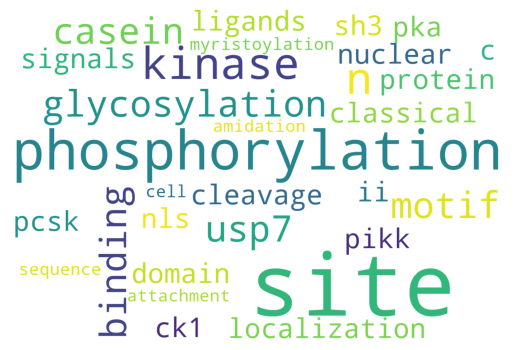

In [119]:
words=''
for name in elm_matches['name']:
    new_words=name.lower()
    words +=new_words+" "
    
for desc in prosite_matches['descr']:
    new_words=desc.lower()
    words +=new_words+" "
    
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
fig,ax=plt.subplots()
ax.set_axis_off()
ax.imshow(wordcloud)
fig.savefig('Figures/5_patterns_wordcloud.png')